# Notebook for Setting Up, Training, and Visualization of MultiVI‑Splice (MuData Version)

This notebook assumes that a combined MuData object has already been created (using your other notebook).
It will:
1. Load the combined MuData (made by `ann_data_maker.ipynb`).
2. Set up MultiVI‑Splice with the MuData object.
3. Train the model (with optional W&B logging).
4. Save (and optionally reload) the model.
5. Retrieve imputed splicing and expression estimates.
6. Visualize the latent representation via UMAP.
7. Optionally write out the updated MuData object.

## 0. Configure Paths

In [2]:
MUDATA_PATH = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/072025/MASKED_0.2_test_30_70_ge_splice_combined_20250730_164104.h5mu"
MODEL_SAVE_DIR = "/gpfs/commons/home/svaidyanathan/multi_vi_splice_runs/MultiVISpliceTraining_20250527_101310_job4884402/models"
IMPUTED_DFS_PATH = "/gpfs/commons/home/svaidyanathan/dfs/imputed_dfs.h5"
OUTPUT_UPDATED_MUDATA = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTVI_TMS_BRAINONLY_MUDATA_GE_ATSE.h5mu"

print("MuData path:", MUDATA_PATH)
print("Model save directory:", MODEL_SAVE_DIR)
print("Imputed DataFrames path:", IMPUTED_DFS_PATH)
print("Output updated MuData path:", OUTPUT_UPDATED_MUDATA)

MuData path: /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/072025/MASKED_0.2_test_30_70_ge_splice_combined_20250730_164104.h5mu
Model save directory: /gpfs/commons/home/svaidyanathan/multi_vi_splice_runs/MultiVISpliceTraining_20250527_101310_job4884402/models
Imputed DataFrames path: /gpfs/commons/home/svaidyanathan/dfs/imputed_dfs.h5
Output updated MuData path: /gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTVI_TMS_BRAINONLY_MUDATA_GE_ATSE.h5mu


## 1. Imports

In [3]:
import scvi  # your local copy of scvi-tools

print("scvi version:", getattr(scvi, "__version__", "No version attr"))
print("scvi loaded from:", scvi.__file__)

import anndata as ad
import mudata as mu
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import wandb
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/

scvi version: 1.3.1
scvi loaded from: /gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/__init__.py


## 2. Initialize W&B Logger (Optional)Loading in our stacked annData (created using the ann_data_maker notebook).

In [3]:
wandb_logger = WandbLogger(project="multivi-splice")  

## 3. Load  MuData

We assume this MuData has all necessary fields.

In [4]:
mdata = mu.read_h5mu(MUDATA_PATH)

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
n_tms = len(mdata.obs[mdata.obs["dataset"] == "AB"])
print(n_tms)

49365


In [5]:
mdata

MuData object with n_obs × n_vars = 41381 × 137772
  obs:	'cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'medium_cell_type', 'specific_cell_type', 'cell_id_index', 'cell_name', 'modality', 'age_numeric'
  var:	'gene_name', 'gene_id', 'ID', 'modality'
  obsm:	'X_library_size'
  2 modalities
    rna:	41381 x 13394
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'specific_cell_type', 'broad_cell_type', 'medium_cell_type', 'seqtech', 'library_size', 'total_junction_reads', 'annotated_junction_reads', 'unannotated_junction_reads', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'AgingScore_unweighted', 'AgingScore_pos', 'AgingScore_neg', 'nuclear_ratio_log_norm', 'modality', 'age_numeric'
      var:	'index', 'gene_name', 'gene_id', 'mean_transcript_length', 'mean_intron_length', 'num_transcripts', 'transcript_biotypes', 'is_rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'ID', 'modality'
      uns:	'hvg'
      obsm:	'X_library_size'
      layers:	'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'
    splicing:	41381 x 124378
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'specific_cell_type', 'broad_cell_type', 'medium_cell_type', 'seqtech', 'library_size', 'total_junction_reads', 'annotated_junction_reads', 'unannotated_junction_reads', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'AgingScore_unweighted', 'AgingScore_pos', 'AgingScore_neg', 'nuclear_ratio_log_norm', 'modality', 'age_numeric'
      var:	'junction_id', 'event_id', 'splice_motif', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'junction_id_index', 'n_cells_detected', 'confidence', 'ID', 'modality'
      obsm:	'X_library_size'
      layers:	'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio', 'junc_ratio_masked_original', 'psi_mask'

In [6]:
print(mdata["splicing"].layers["psi_mask"])

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 368613270 stored elements and shape (41381, 124378)>
  Coords	Values
  (0, 97)	1
  (0, 98)	1
  (0, 246)	1
  (0, 247)	1
  (0, 248)	1
  (0, 260)	1
  (0, 261)	1
  (0, 262)	1
  (0, 263)	1
  (0, 264)	1
  (0, 265)	1
  (0, 266)	1
  (0, 267)	1
  (0, 268)	1
  (0, 478)	1
  (0, 479)	1
  (0, 481)	1
  (0, 578)	1
  (0, 579)	1
  (0, 583)	1
  (0, 881)	1
  (0, 882)	1
  (0, 883)	1
  (0, 1218)	1
  (0, 1219)	1
  :	:
  (41380, 124142)	1
  (41380, 124158)	1
  (41380, 124159)	1
  (41380, 124160)	1
  (41380, 124161)	1
  (41380, 124162)	1
  (41380, 124163)	1
  (41380, 124164)	1
  (41380, 124165)	1
  (41380, 124166)	1
  (41380, 124167)	1
  (41380, 124168)	1
  (41380, 124169)	1
  (41380, 124170)	1
  (41380, 124171)	1
  (41380, 124172)	1
  (41380, 124173)	1
  (41380, 124174)	1
  (41380, 124175)	1
  (41380, 124178)	1
  (41380, 124179)	1
  (41380, 124273)	1
  (41380, 124274)	1
  (41380, 124275)	1
  (41380, 124276)	1


In [7]:
print(mdata["splicing"].layers["junc_ratio_masked_original"])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35299748 stored elements and shape (41381, 124378)>
  Coords	Values
  (0, 6024)	1.0
  (0, 7662)	1.0
  (0, 10220)	1.0
  (0, 11266)	0.42105263157894735
  (0, 11268)	0.5789473684210527
  (0, 13182)	0.3037974683544304
  (0, 13183)	0.6962025316455697
  (0, 13944)	1.0
  (0, 15697)	1.0
  (0, 25891)	1.0
  (0, 26263)	1.0
  (0, 29579)	1.0
  (0, 29588)	0.5853658536585366
  (0, 29591)	0.4146341463414634
  (0, 31089)	0.4107142857142857
  (0, 31097)	0.5892857142857143
  (0, 31448)	1.0
  (0, 32082)	1.0
  (0, 32315)	1.0
  (0, 32875)	1.0
  (0, 38943)	1.0
  (0, 39482)	1.0
  (0, 40274)	1.0
  (0, 40907)	1.0
  (0, 40928)	0.43037974683544306
  :	:
  (41380, 121657)	0.4696969696969697
  (41380, 121659)	0.4393939393939394
  (41380, 121785)	1.0
  (41380, 122084)	1.0
  (41380, 122159)	0.4
  (41380, 122161)	0.6
  (41380, 122820)	1.0
  (41380, 123155)	1.0
  (41380, 123473)	1.0
  (41380, 123600)	0.2
  (41380, 123603)	0.8
  (41380, 123606)	0.470588235294

In [8]:
import numpy as np
from scipy import sparse

ad = mdata["splicing"]  # or however you have it loaded

# 1) Get the layer with original values for masked positions
JMO = ad.layers["junc_ratio_masked_original"]
if not sparse.issparse(JMO):
    JMO = sparse.csr_matrix(JMO)

# 2) Build a junction->ATSE membership matrix E (shape: n_junc x n_atse)
event_ids = ad.var["event_id"].to_numpy()
uniq_atse, atse_codes = np.unique(event_ids, return_inverse=True)  # atse_codes: per-junction int code
n_junc = ad.n_vars
n_atse = uniq_atse.size

rows = np.arange(n_junc, dtype=np.int64)
cols = atse_codes.astype(np.int64)
data = np.ones(n_junc, dtype=np.int8)
E = sparse.csr_matrix((data, (rows, cols)), shape=(n_junc, n_atse))

# 3) From JMO>0, get which ATSEs were (detectably) masked per cell
M = JMO.copy()
M.data = (M.data > 0).astype(np.int8)             # binarize: nonzero -> 1
A = (M @ E)                                       # shape: n_cells x n_atse, counts >=1 if any junction hit
A.data = (A.data > 0).astype(np.int8)             # binarize to {0,1}

# 4) Expand back to junctions: any junction in a masked ATSE -> 1
B = (A @ E.T)                                     # shape: n_cells x n_junc
B.data = (B.data > 0).astype(np.int8)

# 5) Store as a new layer
ad.layers["junc_ratio_masked_bin_mask"] = B.tocsr()
print("Wrote layer 'junc_ratio_masked_bin_mask' (sparse {B.shape[0]}x{B.shape[1]}).")


Wrote layer 'junc_ratio_masked_bin_mask' (sparse {B.shape[0]}x{B.shape[1]}).


In [9]:
mdata.write_h5mu(MUDATA_PATH)

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
mdata

MuData object with n_obs × n_vars = 41381 × 137772
  obs:	'cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'medium_cell_type', 'specific_cell_type', 'cell_id_index', 'cell_name', 'modality', 'age_numeric'
  var:	'gene_name', 'gene_id', 'ID', 'modality'
  obsm:	'X_library_size'
  2 modalities
    rna:	41381 x 13394
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'specific_cell_type', 'broad_cell_type', 'medium_cell_type', 'seqtech', 'library_size', 'total_junction_reads', 'annotated_junction_reads', 'unannotated_junction_reads', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'AgingScore_unweighted', 'AgingScore_pos', 'AgingScore_neg', 'nuclear_ratio_log_norm', 'modality', 'age_numeric'
      var:	'index', 'gene_name', 'gene_id', 'mean_transcript_length', 'mean_intron_length', 'num_transcripts', 'transcript_biotypes', 'is_rRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'ID', 'modality'
      uns:	'hvg'
      obsm:	'X_library_size'
      layers:	'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'
    splicing:	41381 x 124378
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'specific_cell_type', 'broad_cell_type', 'medium_cell_type', 'seqtech', 'library_size', 'total_junction_reads', 'annotated_junction_reads', 'unannotated_junction_reads', 'n_detected_annotated_junctions', 'n_detected_unannotated_junctions', 'AgingScore_unweighted', 'AgingScore_pos', 'AgingScore_neg', 'nuclear_ratio_log_norm', 'modality', 'age_numeric'
      var:	'junction_id', 'event_id', 'splice_motif', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'junction_id_index', 'n_cells_detected', 'confidence', 'ID', 'modality'
      obsm:	'X_library_size'
      layers:	'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio', 'junc_ratio_masked_original', 'psi_mask', 'junc_ratio_masked_bin_mask'

In [16]:
mask_layer = mdata["splicing"].layers["junc_ratio_masked_bin_mask"]

if hasattr(mask_layer, "nonzero"):  # sparse or dense both have this
    _, masked_junc_indices = mask_layer.nonzero()
    unique_masked_juncs = np.unique(masked_junc_indices)
    print("Number of unique masked junctions:", unique_masked_juncs.size)


Number of unique masked junctions: 123919


In [ ]:
from scipy import sparse
import numpy as np

mdata = mu.read_h5mu(MUDATA_PATH)

# grab the splicing modality
splicing = mdata["splicing"]

# 1) load cluster‐ and junction‐counts
cluster = splicing.layers["cell_by_cluster_matrix"]
junction = splicing.layers["cell_by_junction_matrix"]

# 2) ensure CSR
if not sparse.isspmatrix_csr(cluster):
    cluster = sparse.csr_matrix(cluster)
if not sparse.isspmatrix_csr(junction):
    junction = sparse.csr_matrix(junction)

# 3) build psi_mask (1 wherever cluster>0)
mask = cluster.copy()
mask.data = np.ones_like(mask.data, dtype=np.uint8)
splicing.layers["psi_mask"] = mask

# 4) compute junc_ratio = junction / cluster, nan→0
#    convert to dense for element‐wise division
cluster_arr = cluster.toarray()
junction_arr = junction.toarray()
junc_ratio = np.divide(
    junction_arr,
    cluster_arr,
    out=np.zeros_like(junction_arr, dtype=float),
    where=(cluster_arr != 0)
)
# 5) assign back (dense array is fine here)
splicing.layers["junc_ratio"] = junc_ratio

print(junc_ratio)

print("Now splicing layers:", splicing.layers.keys())
print(f"Mask: {mask}")
print(f"junc_ratio shape: {junc_ratio.shape}")
import gc
del cluster, junction, cluster_arr, junction_arr, mask
gc.collect()  # give Python a nudge to free the memory


KeyboardInterrupt: 

In [ ]:
print("MuData modalities loaded:", list(mdata.mod.keys()))
print(mdata)

MuData modalities loaded: ['rna', 'splicing']
MuData object with n_obs × n_vars = 83321 × 53867
  obs:	'cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'cell_id_index', 'cell_name', 'modality'
  obsm:	'X_library_size'
  2 modalities
    rna:	83321 x 19022
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'broad_cell_type', 'seqtech', 'modality'
      var:	'ID', 'modality'
      obsm:	'X_library_size'
      layers:	'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'
    splicing:	83321 x 34845
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'broad_cell_type', 'seqtech', 'modality'
      var:	'ID', 'modality'
      layers:	'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio', 'psi_mask'


## 3. Set Up MultiVI‑Splice Model Using the MuData Object

Use `setup_mudata` to register modalities. Here, adjust the keys to match those in your MuData.

For this example, we assume:
- The GE AnnData (for gene expression) is under modality key `"rna"` with its raw counts in `"raw_counts"`.
- The ATSE AnnData (for splicing) is used for raw junction counts and the two additional splicing layers.
  

In [8]:
scvi.model.MULTIVISPLICE.setup_mudata(
    mdata,
    batch_key="dataset",
    size_factor_key = "X_library_size",
    rna_layer="raw_counts",
    junc_ratio_layer="junc_ratio",
    atse_counts_layer="cell_by_cluster_matrix",
    psi_mask_layer="psi_mask",
    junc_counts_layer="cell_by_junction_matrix",
    modalities={"rna_layer": "rna", "junc_ratio_layer": "splicing"},
)

model = scvi.model.MULTIVISPLICE(
    mdata,
    n_genes=(mdata["rna"].var["modality"] == "Gene_Expression").sum(),
    n_junctions=(mdata["splicing"].var["modality"] == "Splicing").sum(),
    splicing_architecture="partial",
    expression_architecture = "linear"
    
)
model.view_anndata_setup()

INFO     Generating sequential column names                                                                        


/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[junc_ratio] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Anndata setup with scvi-tools version 1.3.1.

Setup via `MULTIVISPLICE.setup_anndata` with arguments:

{
│   'rna_layer': 'raw_counts',
│   'junc_ratio_layer': 'junc_ratio',
│   'atse_counts_layer': 'cell_by_cluster_matrix',
│   'junc_counts_layer': 'cell_by_junction_matrix',
│   'psi_mask_layer': 'psi_mask',
│   'batch_key': 'dataset',
│   'size_factor_key': 'X_library_size',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna', 'junc_ratio_layer': 'splicing'}
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│    n_atse_counts_key     │ 34845 │
│         n_batch          │   2   │
│         n_cells          │ 83321 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│    n_junc_counts_key     │ 34845 │
│       n_junc_ratio       │ 34845 │
│         n_labels         │   1   │
│   n_psi_observed_mask    │ 34845 │
│      n_size_factor       │   1   │
│          n_vars          │ 19022 │
└──────────────────────────┴───────┘

                                 Data Registry                                 
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃                   scvi-tools Location                   ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │          adata.mod['rna'].layers['raw_counts']          │
│  atse_counts_key  │ adata.mod['splicing'].layers['cell_by_cluster_matrix']  │
│       batch       │                adata.obs['_scvi_batch']                 │
│       ind_x       │                  adata.obs['_indices']                  │
│  junc_counts_key  │ adata.mod['splicing'].layers['cell_by_junction_matrix'] │
│    junc_ratio     │       adata.mod['splicing'].layers['junc_ratio']        │
│      labels       │                adata.obs['_scvi_labels']                │
│ psi_observed_mask │        adata.mod['splicing'].layers['psi_mask']         │
│    size_factor    │              adata.obsm['X_library_size']               │
└───────────────────┴─────────────────────────────────────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │     AB     │          0          │
│                      │    TMS     │          1          │
└──────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [9]:
wandb.init()
wandb.watch(
    model.module,          # the torch.nn.Module you want to instrument
    log="all",             # you can choose "gradients", "parameters", or "all"
    log_freq=1000,         # how often (in steps) to log
    log_graph=False        # True if you also want to log the computational graph
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sv2785 (sv2785-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 5. Train Model (with W&B Logging) and Save

If you don't want to log to W&B, remove `logger=wandb_logger`.

In [ ]:
# 1) Get the embedding module
emb_mod = model.module.z_encoder_splicing.feature_embedding

# 2) If it’s an nn.Embedding layer, grab .weight; otherwise emb_mod is already the weight matrix
weight_tensor = getattr(emb_mod, "weight", emb_mod)

# 3) Detach, move to CPU, convert to NumPy
emb = weight_tensor.detach().cpu().numpy()

# 4) Print shape and contents (or slice if it's huge)
print("Embedding shape:", emb.shape)
print(emb)           # prints the full matrix
# or, for a quick peek:
print(emb[:5, :5])   # first 5 rows × 5 cols

jr_info = model.adata_manager.data_registry["junc_ratio"]
jr_key, mod_key = jr_info.attr_key, jr_info.mod_key

ac_info = model.adata_manager.data_registry["atse_counts_key"]
ac_key = ac_info.attr_key

# 2) Grab as CSR matrices
X = model.adata["splicing"].layers["junc_ratio"]

print(X)
C = model.adata["splicing"].layers[ac_key]


Embedding shape: (34845, 32)
[[-2.7411268e-03 -2.3917079e-03 -3.3488304e-03 ...  1.2711711e-03
   6.2430697e-04 -2.4435127e-03]
 [ 6.0458169e-03  4.9132393e-03  5.9671230e-03 ... -5.8899377e-04
  -1.3689935e-04  4.1225753e-03]
 [-3.3046904e-03 -2.5215312e-03 -2.6182928e-03 ... -6.8217737e-04
  -4.8740761e-04 -1.6790627e-03]
 ...
 [-6.3446158e-04  7.1660063e-04 -4.3251508e-05 ... -3.7272475e-04
   1.4077332e-04 -2.5944182e-04]
 [ 7.8454497e-04  3.9830356e-04 -2.0426884e-03 ... -4.8242266e-05
  -1.0929684e-03 -2.4767315e-03]
 [-7.8454497e-04 -3.9830356e-04  2.0426884e-03 ...  4.8242266e-05
   1.0929684e-03  2.4767315e-03]]
[[-0.00274113 -0.00239171 -0.00334883  0.00207232 -0.00218637]
 [ 0.00604582  0.00491324  0.00596712 -0.00479916  0.00500564]
 [-0.00330469 -0.00252153 -0.00261829  0.00272684 -0.00281926]
 [ 0.00045165 -0.00022617  0.00047307 -0.00088143 -0.00082615]
 [-0.00045165  0.00022617 -0.00047307  0.00088143  0.00082615]]
[[0.         0.         0.         ... 0.         0.   

In [10]:
model.train(logger=wandb_logger, lr_scheduler_type = "step", max_epochs = 5, step_size = 1, n_epochs_kl_warmup = 3)

model.save(MODEL_SAVE_DIR, overwrite=True)
print(f"Model saved to: {MODEL_SAVE_DIR}")

/scratch/ipykernel_731740/1766533688.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(logger=wandb_logger, lr_scheduler_type = "step", max_epochs = 5, step_size = 1, n_epochs_kl_warmup = 3)
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/svaidyanathan/miniconda3

Using step LR


Training:   0%|          | 0/5 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model saved to: /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/multivisplice


## 6. (Optional) Reload Model

Reload the trained model from disk if you want to use it in a new session.

In [3]:
mdata = mu.read_h5mu(MUDATA_PATH)
model = scvi.model.MULTIVISPLICE.load(MODEL_SAVE_DIR, adata=mdata)
print("Model reloaded. Current AnnData shape:", mdata.shape)

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


INFO     File                                                                                                      
         /gpfs/commons/home/svaidyanathan/multi_vi_splice_runs/MultiVISpliceTraining_20250527_101310_job4884402/mod
         els/model.pt already downloaded                                                                           


/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/svaidyanathan/miniconda3/envs/scv ...
/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[junc_ratio] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


: 

In [ ]:
print(model._model_summary_string)

## 7. Retrieve Imputed Splicing/Expression

- `get_splicing_estimates()` returns imputed splicing usage ratios.
- `get_normalized_expression()` returns normalized gene expression.
- We store them in an HDF5 file for further analysis.

In [6]:

imputed_splicing_estimates = model.get_normalized_splicing()
imputed_expression_estimates = model.get_normalized_expression()

print("Splicing estimates  →  min:", np.min(imputed_splicing_estimates), " max:", np.max(imputed_splicing_estimates))
print("Expression estimates →  min:", np.min(imputed_expression_estimates), " max:", np.max(imputed_expression_estimates))

Splicing estimates  →  min: 0.00023978903  max: 0.99956936
Expression estimates →  min: 1.2423068e-07  max: 0.10490193


In [10]:
print(mdata["rna"])

AnnData object with n_obs × n_vars = 83321 × 19022
    obs: 'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'broad_cell_type', 'seqtech', 'modality'
    var: 'ID', 'modality'
    obsm: 'X_library_size'
    layers: 'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'


## 8. Visualize Latent Representation (UMAP)

1. Add the model's latent representation to `.obsm`.
2. Calculate neighbors/UMAP.
3. Plot with different color labels.

Getting the latent representation and adding it as an obsm field called "X_multivi"

In [17]:
print("Computing latent representation and UMAP...")
latent_key = "X_multivi"
mdata["rna"].obsm[latent_key] = model.get_latent_representation(modality = "expression")

sc.pp.neighbors(mdata["rna"], use_rep=latent_key)
sc.tl.umap(mdata["rna"], min_dist=0.2)
print("UMAP complete.")

Computing latent representation and UMAP...
UMAP complete.


In [ ]:
group = "broad_cell_type"
groups = ['cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'cell_id_index', 'cell_name', 'modality']

for g in groups:
    print(f'___________________________{g}___________________________\n')
    print(f'{mdata.obs[g]})')

___________________________cell_id___________________________

0               A10_B000120
1               A10_B000126
2               A10_B000127
3               A10_B000166
4               A10_B000169
                ...        
157413    US-1250275_E2_S86
157414    US-1250275_E2_S87
157415    US-1250275_E2_S88
157416    US-1250275_E2_S89
157417    US-1250275_E2_S90
Name: cell_id, Length: 157418, dtype: object)
___________________________age___________________________

0         18m
1          3m
2          3m
3          3m
4         18m
         ... 
157413     2m
157414     2m
157415     2m
157416     2m
157417     2m
Name: age, Length: 157418, dtype: category
Categories (4, object): ['2m', '3m', '18m', '24m'])
___________________________cell_ontology_class___________________________

0         basal epithelial cell of tracheobronchial tree
1                                     bulge keratinocyte
2                                           myeloid cell
3                            

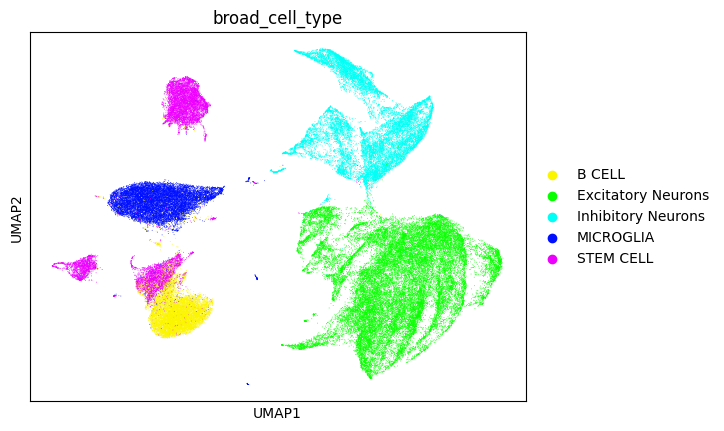

AttributeError: 'NoneType' object has no attribute 'figure'

In [19]:
import os 
import seaborn as sns
group = "broad_cell_type"
mdata["rna"].obs[group] = mdata["rna"].obs[group].astype("category")

categories = mdata["rna"].obs[group].cat.categories
num_categories = len(categories)

palette = sns.color_palette("hsv", num_categories)  # hsv is good for many distinct classes
color_map = dict(zip(categories, palette))

fig = sc.pl.umap(
    mdata["rna"],
    color=group,
    palette=color_map,
    show=True,
    legend_loc='right margin'  # You can also try 'right margin' if you want to show the legend
)

fig_path = os.path.join(
    "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/figures", 
    "umap_broad_cell_type.png"
)
fig.figure.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.close(fig.figure)

## 9. (Optional) Write Updated AnnData

Includes the new `.obsm["X_multivi"]` for further usage.

In [ ]:
combined_adata.write(OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH)
print(f"Updated AnnData with latent space written to: {OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH}")

AnnData object with n_obs × n_vars = 19942 × 77042
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels', 'age', 'sex', 'cell_type_grouped', 'cell_ontology_class'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'GE_X_umap'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'


## 10. Custom Plot Example

Manual plotting with matplotlib if you want custom styling or a side-by-side figure.

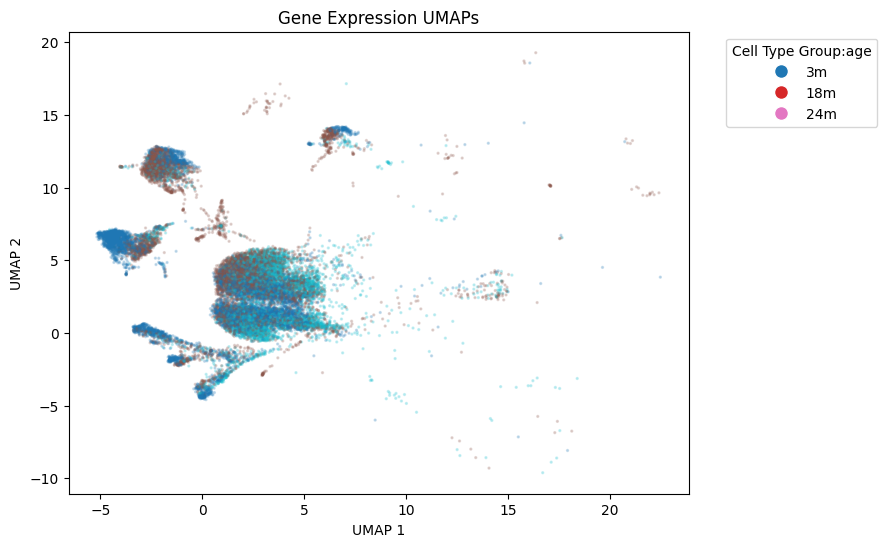

In [ ]:
plt.figure(figsize=(8, 6))
group = "age"  # or any column in combined_adata.obs
if group in combined_adata.obs.columns:
    cell_types = combined_adata.obs[group].astype("category")
    umap_coords = combined_adata.obsm["X_umap"]

    scatter = plt.scatter(
        umap_coords[:, 0],
        umap_coords[:, 1],
        c=cell_types.cat.codes,
        cmap="tab10",
        alpha=0.2,
        s=2
    )
    legend_labels = cell_types.cat.categories
    legend_handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
            markersize=10
        )
        for i in range(len(legend_labels))
    ]
    plt.legend(
        legend_handles, legend_labels,
        title=f"UMAP colored by: {group}",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP (field: {group})")
    plt.show()
else:
    print(f"Column '{group}' not found in .obs.")